# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
filename="../Lab.7/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

In [3]:
# Import sklearn libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [4]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [5]:
# Prepare training and test sets
N_Train = 4000000
Train_Sample = df[:N_Train]
Test_Sample = df[N_Train:]

X_Train = Train_Sample[VarNames[1:]]
y_Train = Train_Sample["signal"]
X_Test = Test_Sample[VarNames[1:]]
y_Test = Test_Sample["signal"]

Test_sig = Test_Sample[Test_Sample.signal == 1]
Test_bkg = Test_Sample[Test_Sample.signal == 0]

# Reduced subsets for speed
X_Train_small = X_Train[:100000]
y_Train_small = y_Train[:100000]
X_Test_small = X_Test[:50000]
y_Test_small = y_Test[:50000]

We can train the classifier as follow:

In [6]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

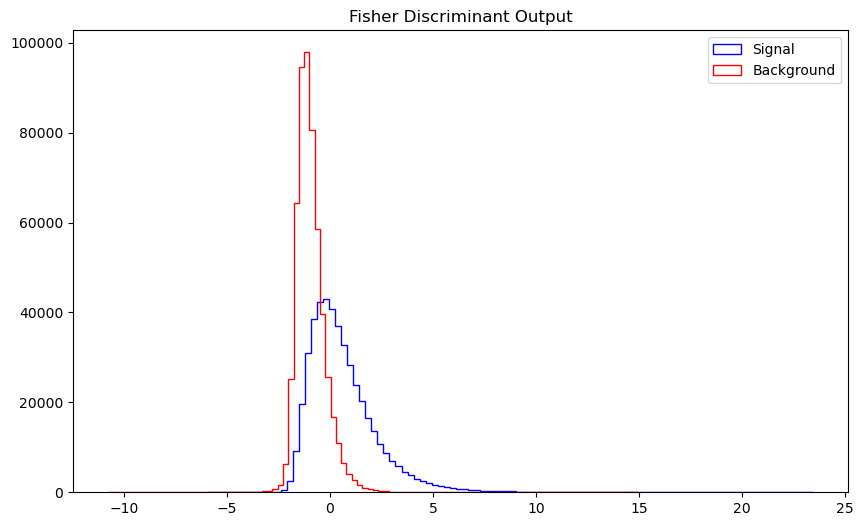

In [7]:
# Plot signal vs background
plt.figure(figsize=(10,6))
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]), bins=100, histtype="step", color="blue", label="Signal")
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]), bins=100, histtype="step", color="red", label="Background")
plt.legend(loc='upper right')
plt.title("Fisher Discriminant Output")
plt.show()


#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

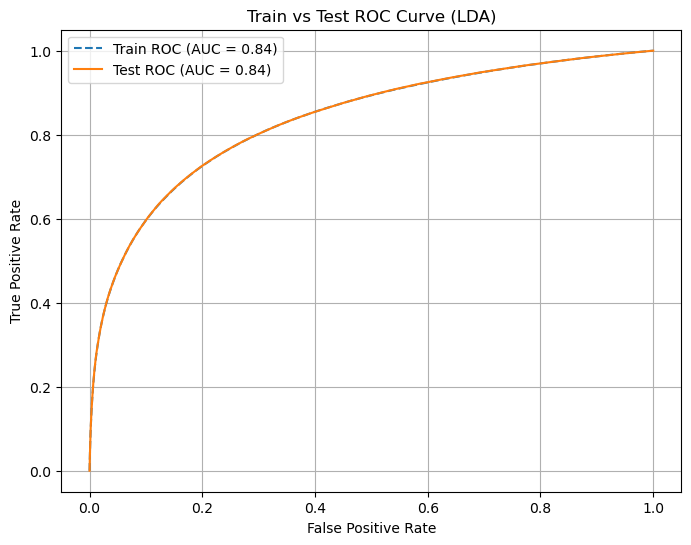

In [8]:
# ROC for train
train_fpr, train_tpr, _ = roc_curve(y_Train, Fisher.decision_function(X_Train))
train_auc = auc(train_fpr, train_tpr)

# ROC for test
test_fpr, test_tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))
test_auc = auc(test_fpr, test_tpr)

plt.figure(figsize=(8,6))
plt.plot(train_fpr, train_tpr, label=f"Train ROC (AUC = {train_auc:.2f})", linestyle='--')
plt.plot(test_fpr, test_tpr, label=f"Test ROC (AUC = {test_auc:.2f})", linestyle='-')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train vs Test ROC Curve (LDA)")
plt.legend()
plt.grid()
plt.show()


#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

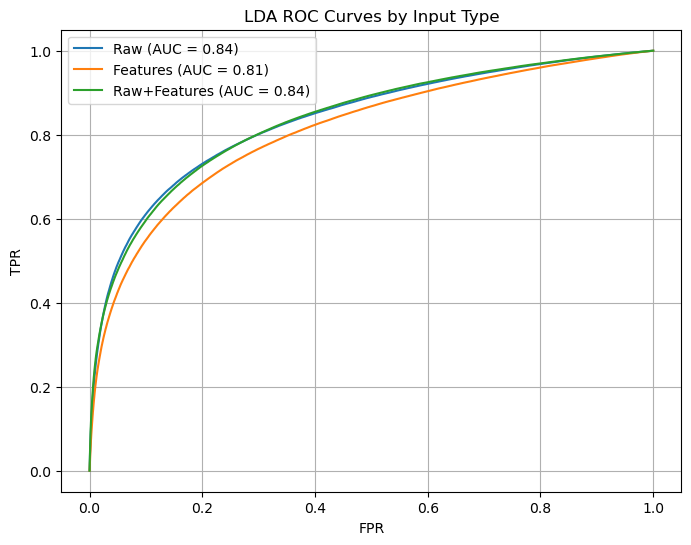

In [9]:
raw_vars = VarNames[1:11]
feat_vars = VarNames[11:]
all_vars = VarNames[1:]

def lda_auc_plot(X_vars, label):
    clf = DA.LinearDiscriminantAnalysis()
    clf.fit(X_Train[X_vars], y_Train)
    fpr, tpr, _ = roc_curve(y_Test, clf.decision_function(X_Test[X_vars]))
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")

plt.figure(figsize=(8,6))
lda_auc_plot(raw_vars, "Raw")
lda_auc_plot(feat_vars, "Features")
lda_auc_plot(all_vars, "Raw+Features")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("LDA ROC Curves by Input Type")
plt.grid()
plt.show()


### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)
    y_pred = clf.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)

    # Compute significance safely
    Ns = sum(y_test)
    Nb = len(y_test) - Ns
    max_sig = 0
    for eps_s, eps_b in zip(tpr, fpr):
        Ns_prime = eps_s * Ns
        Nb_prime = eps_b * Nb
        if Ns_prime + Nb_prime > 0:
            sigma = Ns_prime / np.sqrt(Ns_prime + Nb_prime)
            if not np.isnan(sigma) and sigma > max_sig:
                max_sig = sigma

    return {
        "Classifier": clf.__class__.__name__,
        "AUC": auc(fpr, tpr),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Max_Significance": max_sig
    }


In [11]:
# Classifiers (tuned for speed)
classifiers = [
    DA.LinearDiscriminantAnalysis(),
    LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1),
    RandomForestClassifier(n_estimators=20, max_depth=10, n_jobs=-1),
    GaussianNB()
]

# Evaluate on reduced dataset
results = [evaluate_classifier(clf, X_Train_small, y_Train_small, X_Test_small, y_Test_small) for clf in classifiers]
results_df = pd.DataFrame(results)
results_df


,Classifier,AUC,Precision,Recall,F1,Accuracy,Max_Significance
0,LinearDiscriminantAnalysis,0.836035,0.844269,0.578060,0.686252,0.75928,112.390747
1,LogisticRegression,0.856645,0.830997,0.674147,0.744399,0.78916,114.857361
2,RandomForestClassifier,0.862042,0.826425,0.695226,0.755170,0.79470,115.848889
3,GaussianNB,0.808826,0.801363,0.552589,0.654121,0.73386,108.838161


In [12]:
# Train best model (Random Forest, optimized)
best_model = RandomForestClassifier(n_estimators=20, max_depth=10, n_jobs=-1)
best_model.fit(X_Train_small, y_Train_small)

# Predict probabilities and compute ROC
y_score = best_model.predict_proba(X_Test_small)[:, 1]
fpr, tpr, _ = roc_curve(y_Test_small, y_score)

# Safe significance computation
N_S = sum(y_Test_small)
N_B = len(y_Test_small) - N_S
max_sig = 0
for eps_s, eps_b in zip(tpr, fpr):
    N_Sp = eps_s * N_S
    N_Bp = eps_b * N_B
    if N_Sp + N_Bp > 0:
        sig = N_Sp / np.sqrt(N_Sp + N_Bp)
        if not np.isnan(sig) and sig > max_sig:
            max_sig = sig

print("Max significance (σₛ) =", round(max_sig, 3))

Max significance (σₛ) = 115.721


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

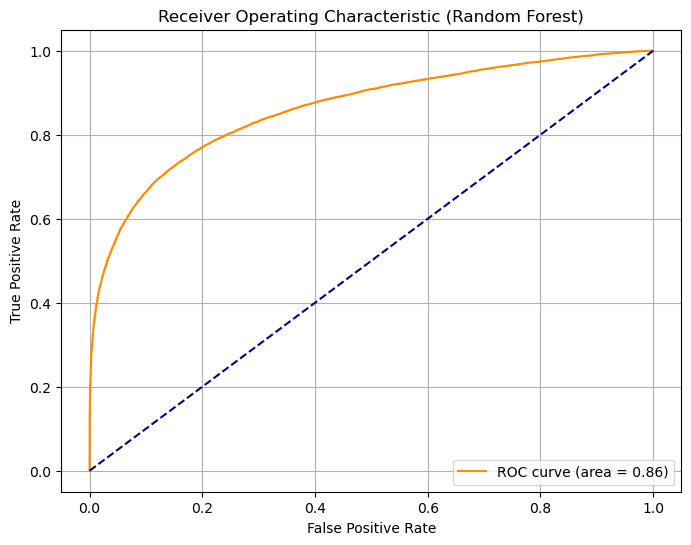

In [13]:
from sklearn.metrics import roc_curve, auc

# Train the best model (optimized)
best_clf = RandomForestClassifier(n_estimators=20, max_depth=10, n_jobs=-1)
best_clf.fit(X_Train_small, y_Train_small)

# Predict probabilities and compute ROC
y_score = best_clf.predict_proba(X_Test_small)[:, 1]
fpr, tpr, _ = roc_curve(y_Test_small, y_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Random Forest)')
plt.legend(loc="lower right")
plt.grid()
plt.show()



#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


In [14]:
from sklearn.metrics import classification_report

# Evaluate metrics for each classifier on the small subset
metrics_table = []

for clf in classifiers:
    metrics_table.append(evaluate_classifier(clf, X_Train_small, y_Train_small, X_Test_small, y_Test_small))

# Display results as a DataFrame
results_df = pd.DataFrame(metrics_table)
results_df


,Classifier,AUC,Precision,Recall,F1,Accuracy,Max_Significance
0,LinearDiscriminantAnalysis,0.836035,0.844269,0.578060,0.686252,0.75928,112.390747
1,LogisticRegression,0.856645,0.830997,0.674147,0.744399,0.78916,114.857361
2,RandomForestClassifier,0.862084,0.825026,0.696368,0.755257,0.79446,115.871971
3,GaussianNB,0.808826,0.801363,0.552589,0.654121,0.73386,108.838161
